# **Estruturas criptográficas 2024-2025**
**Grupo 02**

**Pg55986:** Miguel Ângelo Martins Guimarães 

**Pg55997:** Pedro Miguel Oliveira Carvalho 

Universidade do Minho, Março 2025

***
# **Exercicio 2**

### **Enunciado do exercicio:**

2. Construir uma classe Python que implemente o EcDSA a partir do “standard” *FIPS186-5*:

    - A implementação deve conter funções para assinar digitalmente e verificar a assinatura.
    - A implementação da classe deve usar  uma das “Twisted Edwards Curves” definidas no standard e escolhida na iniciação da classe: a curva  “edwards25519” ou “edwards448”.



### **Interpretação do enunciado:**
O “standard” *FIPS186-5* especifica o Digital Signature Standard (DSS), que define os algoritmos que são utilizados para implementar assinaturas digitais, incluindo o EdDSA, bem como as curvas elípticas que devem ser utilizadas para a sua implementação.

<div class="alert alert-block alert-info">
<b>Note:</b> Durante a interpretação do enunciado, surgiu uma dúvida em relação ao que é pedido. O exercício solicita a implementação do EcDSA, no entanto, nas alíneas seguintes, é indicado que devem ser utilizadas curvas de Edwards na implementação, o que não é compatível com o ECDSA, já que este normalmente utiliza curvas de Weierstrass.

Assumimos então que a intenção do enunciado era pedir a implementação do EdDSA (Edwards-Curve Digital Signature Algorithm) com base no “standard” *FIPS186-5*.
</div>

### **Analise do FIPS186-5:**

#### **Contexto geral da utilização de assinaturas:**

Um algoritmo de assinatura digital permite garantir a autenticidade, integridade e não repúdio de uma mensagem. Isto significa que é possível verificar que o emissor da mensagem é realmente quem afirma ser (autenticidade), que a mensagem não foi alterada durante a transmissão (integridade), e que o autor da mensagem não pode negar que a enviou (não repúdio).

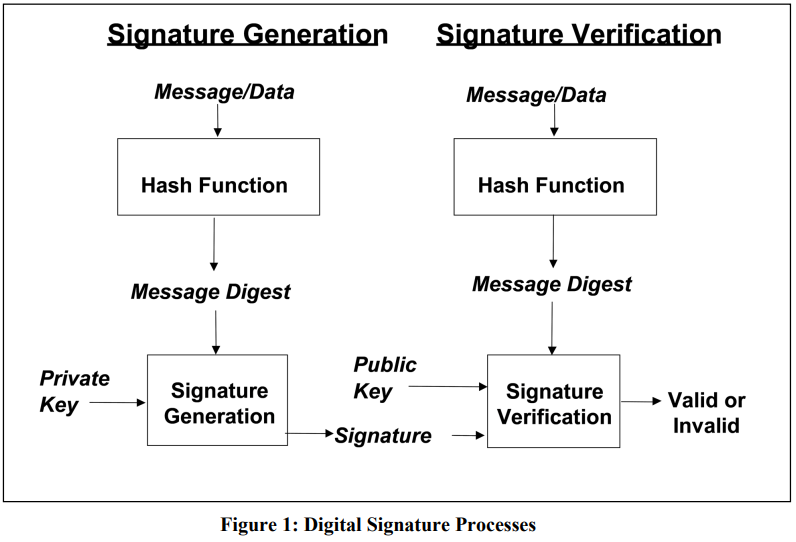

Nesta figura é possível observar o funcionamento das assinaturas digitais.
Durante o processo de geração da assinatura, o emissor utiliza a sua chave privada e a mensagem que pretende enviar para criar uma assinatura digital.

Posteriormente, no processo de verificação da assinatura, o recetor utiliza a chave pública do emissor juntamente com os dados recebidos (mensagem + assinatura) para determinar se a assinatura é válida ou não.

Caso a assinatura seja considerada **inválida**, pode indicar uma das seguintes situações:
- O emissor não é um emissor reconhecido (poderá ter sido utilizada uma chave privada diferente da esperada);
- A integridade da mensagem foi comprometida, ou seja, a mensagem original foi alterada após ter sido assinada pelo emissor.

Deste modo, uma *assinatura digital* válida assegura simultaneamente a *autenticidade* do emissor e a *integridade* da mensagem recebida.

#### **Escolha da curva:**
De acordo com o *FIPS186-5* pode ser utilizada a curva **edwards-25519** ou **edwards-448** para implementar o **edDSA**.

A curva que decidimos escolher na implementação do algoritmo é a curva **ed-25519**,

Após uma leitura do *FIPS186-5* é possivel destacar que os algoritmos de hash utilizados na implementação dos algoritmos de assinatura digital devem utilizar funções de hash aprovadas. Para a implementação do edDSA com a curva **ed-25519** é utilizada a função de hash **SHA-512**.



***
## **Implementação do edDSA**
### **Criação da curva ed-25519**
Para a utilização/implementação da curva **ed-25519** foram utilizadas as classes implementadas pelo professor que se encontravam disponiveis no ficheiro *"Edwards0.ipynb"* fornecido nos anexos da UC.

O ficheiro contém duas classes, a classe **"Ed"** que permite criar uma instancia de uma curva de edwards permitindo obter um ponto gerador na curva de edwards, verificar se um ponto pertence à curva de edwards, entre outras operações. Esta classe implementa a curva de edwards recorrendo a curva de weiterstrass uma vez que esta já se encontra implementada no sage math por default.

A classe **"ed"** permite criar uma instancia de um ponto da curva de edwards, fornecendo metodos que permitem comparar pontos, duplicar, somar e a parte mais importante: multiplicar o ponto por um escalar. Esta operação de multiplicação de um ponto por um escalar é extremamente importante pois encontra-se na base de todo o algoritmo de edDSA.



***
## **Encoding**
No EdDSA é importante representar de forma compacta e eficiente um ponto na curva de Edwards como uma sequência de bytes, reduzindo o espaço necessário para a sua representação.

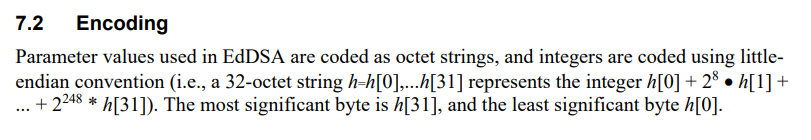

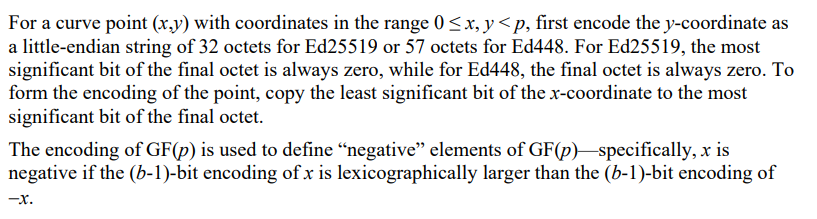

- **Passo 1**: Interpretar o valor *y* como uma sequencia de bytes em formato little-endian.
- **Passo 2**: Copiar o bit menos significativo da coordenada x e colocá-lo no bit mais significativo do último byte de y.

Com esta operação é possivel representar um ponto usando apenas 32 bytes ao invés de 64 (porque o valor *x* não é armazenado de forma explicita).

O bit menos significativo do *x* permite distinguir entre os dois valores de *x* possiveis na curva de *edwards* durante a descodificação.

Assim é possivel obter o valor *x* original a partir de um formato compacto.


***
## **Decoding**
No decoding será recebido como input um ponto da curva de edwards no formato codificado, e é desejado obter a coordenada *x* e *y* do ponto.

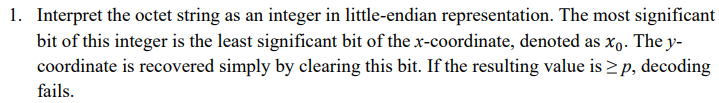

- **Passo 1**: Interpretar o valor codificado como uma sequencia de bytes em formato little-endian. 
- **Passo 2**: Extrair o bit menos significativo do *x*, o valor *x0*, a partir do bit mais significativo do valor codificado. **Nota:** Relembramos que este bit permite distinguir entre os dois valores de *x* possiveis na curva de edwards durante o processo de descodificação.
- **Passo 3**: Obter a coordenada *y* colocando o bit mais significativo a 0. **Nota:** Nesta posição era onde se encontrava o valor *x0*.

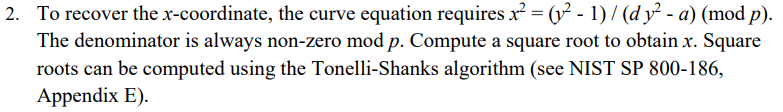
- **Passo 4**: Para obter o valor de *x* teremos que resolver a equação demonstrada na figura. Essa equação é obtida a partir da equação da curva de edwards.
De forma a obter esta equação foi utilizado o algoritmo de Tonelli-Shanks tal como sugerido na figura.
Após a aplicação do algoritmo de tonelli-shanks o valor de x é obtido. O algoritmo encontra-se explicado na secção abaixo.

Consoante o valor de x obtido e o valor x0 é necessário extrair o valor de *x* correto, como tal é realizada uma operação de ```p-x``` para obter o outro valor de *x* caso a paridade seja diferente.

***
## **Tonelli-shanks**
Seguindo o **"NIST SP 800-186"**, tal como sugerido na secção do decoding, é possivel implementar o algoritmo de tonelli-shanks que nos permite obter um valor de *x* a partir de uma equação no formato  ```x2 ≡ n mod p```.


- **Passo 1**: Descobrir os valores q e s, de forma a que a equação ```p-1 = q*2^s``` seja verdade. Para resolver esta equação primeiro foi inicializado o valor *q* igual a ```p-1```, e o valor *s* igual a 0. Depois o valor Q foi iterado, isto é, para o valor de Q atual verificamos qual o resto da sua divisão por 2 a cada iteração. Sempre que o valor *Q* é divisivel por 2 o valor *s* é incrementado em 1 unidade. Assim foi possivel simplificar o valor ```p-1``` para o formato ```p-1 = q*2^s``` obtendo assim os valores finais de *q* e de *s*.

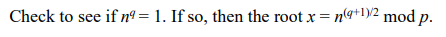

- **Passo 2**: Verificar se ```n^q = 1```. Caso isso acontecer então possuimos imediatamente um valor de *x*. 

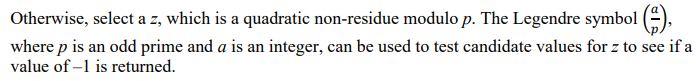

- **Passo 3**: Para esta etapa utilizamos a identidade de euler ```(z/p) == z^(p-1/2)```. O algoritmo utilizado nesta secção é relativamente simples, iteramos todos os valores de *z* de 2 até *p*, e assim que a equação se tornar verdade possuiamos um candidato valido de z.

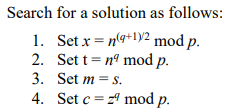

- **Passo 4**: Definir as variaveis x, t, m e c para os valores que se encontram na figura.

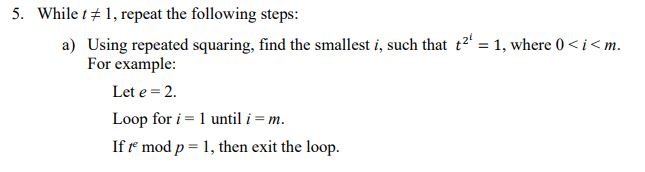

- **Passo 5**: Iterar todos os valores de i possiveis até que a equação ```t^2^i = 1``` seja verdade.

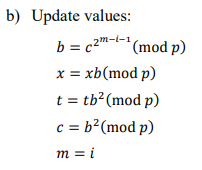

Durante este processo as variaveis *x*, *t*, *m* e *c* são atualizadas.

Todo este processo é repetido enquanto *t* for diferente de 1.
Assim que *t* for igual a 1 possuimos os valores de x que procuravamos.



***
## **Gerar um par de chaves**
A seguir encontra-se descrito como foi implementada a etapa de gerar um par de chaves valido para utilização com o edDSA.  

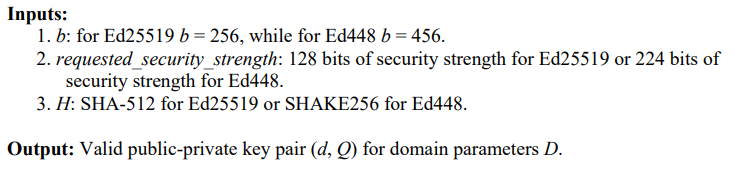

Na figura acima encontram-se os dados de entrada utilizados para a criação da chave privada e da chave publica.

#### Para a criação da chave privada e publica foram seguidos os passos identificados no *FIPS186-5*:
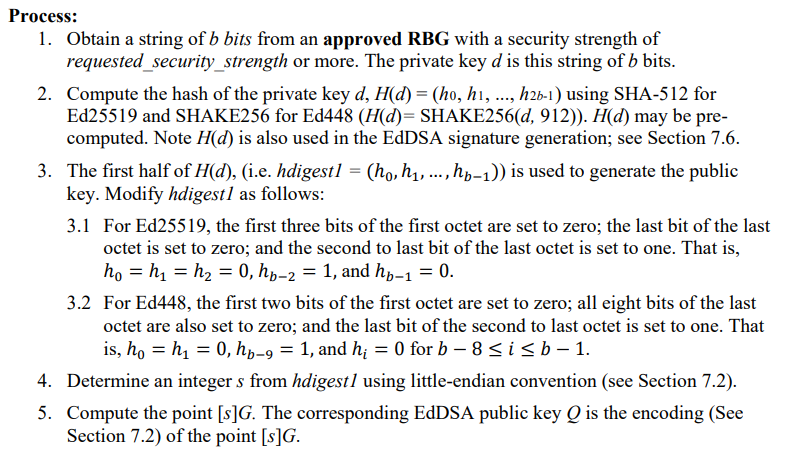

#### **Implementação:**
- **Passo 1**: É necessário obter uma string de b bits proveniente de um gerador de números aleatórios aprovado, que ofereça um nível de segurança compatível com o parâmetro *requested_security_strength*. Como o gerador de *bits* considerado mais robusto é aquele fornecido pelo sistema operacional, conforme mencionado pelo professor, optou-se por utilizar a biblioteca *secrets* do Python, que utiliza as fontes de entropia do próprio sistema para gerar valores aleatórios de forma segura.

- **Passo 2**: Calcular o hash da chave privada utilizando **SHA-512**. Foi utilizado o **SHA-512** utilizando o *cryptography*. 
- **Passo 3**: Extrair a primeira metade do hash criado. 
- **Passo 3.1**: Aplicar transformações na metade extraída, garantindo que o valor esteja no formato correto para uso na curva Ed25519:
  - Definir os três primeiros bits do primeiro octeto como zero (foi implementado utilizando a operação *AND* com `248`, que equivale a `11111000` em binário).
  - Definir o último bit do último octeto como zero (foi implementado utilizando a operação *AND* com `127`, que equivale a `01111111` em binário).
  - Definir o penúltimo bit do último octeto como um (foi implementado utilizando a operação *OR* com `64`, que equivale a `01000000` em binário).

- **Passo 4**: Interpretar o resultado final como um inteiro *s*, assumindo uma codificação *little-endian*.

- **Passo 5**: Calcular o ponto **[s]G**, onde *G* é o gerador da curva. Essa operação consiste em multiplicar *G* pelo escalar *s*, ou seja, calcular *G* somado a si mesmo *s* vezes, utilizando a operação `G.mult(s)`, que implementa multiplicação escalar em curvas elípticas.

***
## **Criação de uma assinatura**
A seguir iremos expor como foi implementada a criação de assinaturas edDSA.

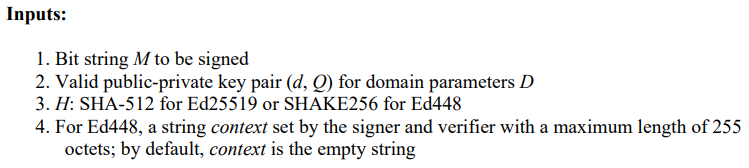

Na figura acima é possivel visualizar quais são os valores de entrada utilizados na criação de uma assinatura digital recorrendo ao **edDSA**.
- É necessário fornecer uma mensagem que será assinada.
- Um par de chaves publica/privada que serão utilizadas no processo de assinatura.
- E é exigida a utilização de **SHA-512** como função de *hash*.

#### **Implementação:**

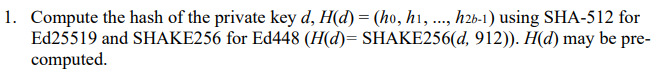

- **Passo 1**: Calcular a hash da chave privada recorrendo ao SHA-512. Este passo foi implementado recorrendo à biblioteca *cryptography*.



- **Passo 2**: Extrair a segunda metade do hash calculado. **Nota:** Relembro que a primeira metade do hash da chave privada é utilizado para gerar a chave publica. 



- **Passo 2.1**: Concatenar a segunda metade do hash com a mensagem. Aplicar a função de hash *SHA-512* ao resultado da concatenação. O *hash* obtido é o valor *r* que vai ser usado no proximo passo.

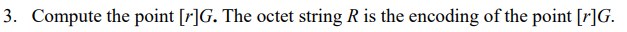

- **Passo 3**: Calcular o ponto **[r]G**, onde *G* é o gerador da curva. O ponto obtido é apelidado de ponto *R*. **Nota:** Relembro que esta operação consiste em multiplicar *G* pelo escalar *r*, obtendo assim um novo ponto sobre a curva de *edwards*.

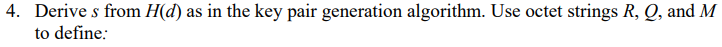

- **Passo 4**: Obter um valor **s** a partir do ponto obtido, utilizando o mesmo processo que na geração das chaves. Para replicar essa etapa iremos utilizar novamente a primeira metade do hash, e com ela vamos realizar as mesmas manipulações aos bits dessa metade tal como na fase de criação de chaves.  

    Ou seja:
    - Definir os três primeiros bits do primeiro octeto como zero (foi implementado utilizando a operação *AND* com `248`, que equivale a `11111000` em binário).
    - Definir o último bit do último octeto como zero (foi implementado utilizando a operação *AND* com `127`, que equivale a `01111111` em binário).
    - Definir o penúltimo bit do último octeto como um (foi implementado utilizando a operação *OR* com `64`, que equivale a `01000000` em binário).

    Depois passamos este valor para inteiro garantindo que respeitamos a notação little-endian.



- **Passo 4.1**: Vamos calcular o valor **S** recorrendo à equação demonstrada na figura acima. Primeiramente devemos concatenar o valor **R** (valor codificado obtido no passo 3) com o valor **Q** (chave publica) e o valor **M** que representa a mensagem. Aplicamos a função de hash **SHA-512** ao resultado da concatenação e multiplicarmos esse valor por **s** (obtido no passo anterior). Somamos o valor **r** (obtido no passo 2.1) ao resultado da operação anterior, finalizando a equação com ```mod n```. 



O resultado final é obtido codificando o valor S.

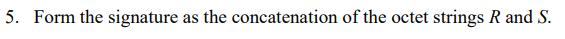

- **Passo 5**: Para finalizar o processo de criação da assinatura concatenamos o valor **R** e **S** e assim obtemos a assinatura da mensagem **M**.

***
## **Verificação da assinatura**

A seguir será demonstrado como foi implementada a verificação de assinaturas **edDSA**.

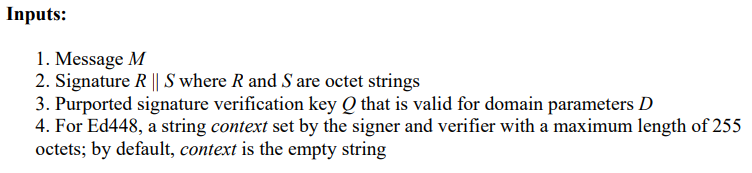

Na figura acima encontram-se representados os dados de entrada da função de verificação de assinaturas **edDSA**. 
Pode-se verificar que os valores de entrada são:
- Uma mensagem que será utilizada no processo de verificação. **Nota:** Para a assinatura ser considerada valida a mensagem utilizada tem de ser a mesma mensagem que foi utilizada durante a criação da assinatura.
- Uma assinatura que será alvo do processo de verificação.
- Uma chave publica. **Nota:** Para a assinatura ser considerada valida a chave publica utilizada tem de ser a mesma que na criação da assinatura.

#### **Implementação**

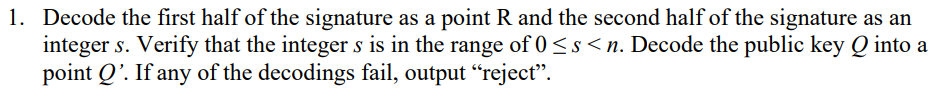

- **Passo 1**: 
    - O primeiro é extrair a primeira metade da assinatura para obter o valor **R**, a segunda metade da assinatura fornece o valor **s**. **Nota:** É necessario descodificar os valores *S* e *R*.
    - Depois verifica-se se o valor **s** se encontra no intervalo de ```0<=s<=n```. **Nota:** Se este passo falhar o processo de verificação é rejeitado. **Nota:** Se este passo falhar o processo de verificação é rejeitado. 
    - Descodificamos a chave publica para obter um ponto. **Nota:** Se este passo falhar o processo de verificação é rejeitado. 

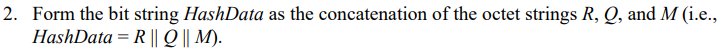

- **Passo 2**: Concatenar os valores **R**, **Q** (chave publica) e **M** (mensagem).



- **Passo 3**: Aplicar a função de hash SHA-512 ao resultado da concatenação. Nota: Este passo foi implementado recorrendo à biblioteca *cryptography*.



É necessário interpretar este resultado como um little-endian. Este é o valor *t*.

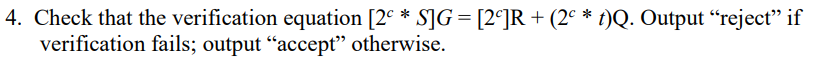

- **Passo 3**: Para finalizar o processo é realizada uma verificação da equação demonstrada na figura. Primeiramente vamos calcular o lado direito, onde calculamos ```2^c```. O valor **c** é 3 tal como enunciado no standard. Multiplicamos 2^c por S e com esse resultado multiplicamos o gerador **G** por esse mesmo escalar. Do lado direito da equação vamos multiplicar o ponto **R** pelo escalar ```2^c``` e somar esse resultado com a aplicação do escalar resultante de ```(2^c * t)``` ao ponto **Q**.

Deste processo surge o resultado final que é "Accept" ou "Reject" (devolvemos true ou false na nossa implementação), que indicam se assinatura é valida ou invalida.

***
## **Testes:**
Para validar este exercicio foram realizados os seguintes testes:

### **Teste de assinatura valida**
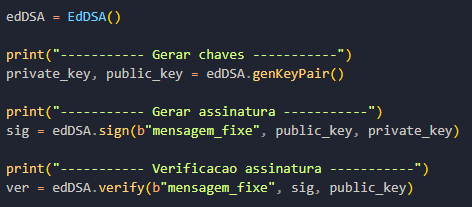

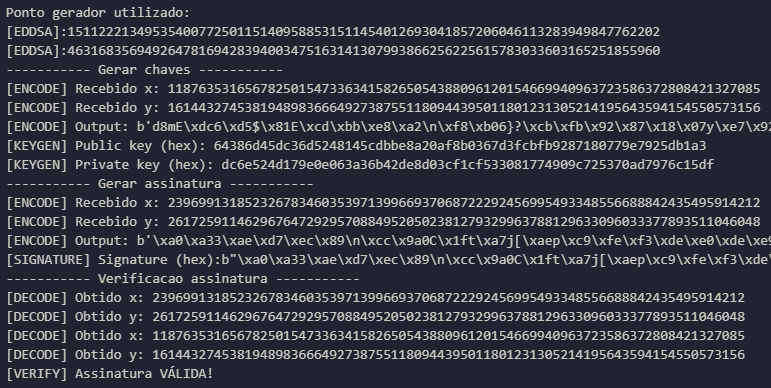

### **Teste de assinatura invalida com mensagem manipulada/diferente**
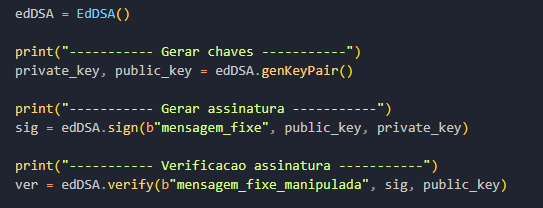

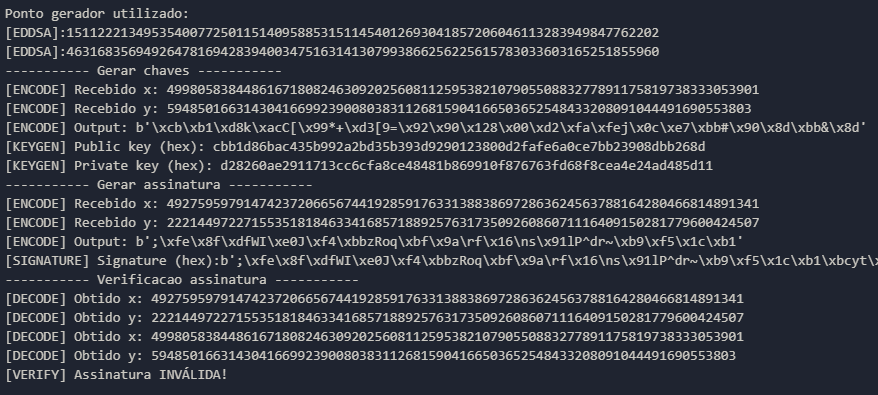

### **Teste de assinatura invalida com uma chave publica diferente**
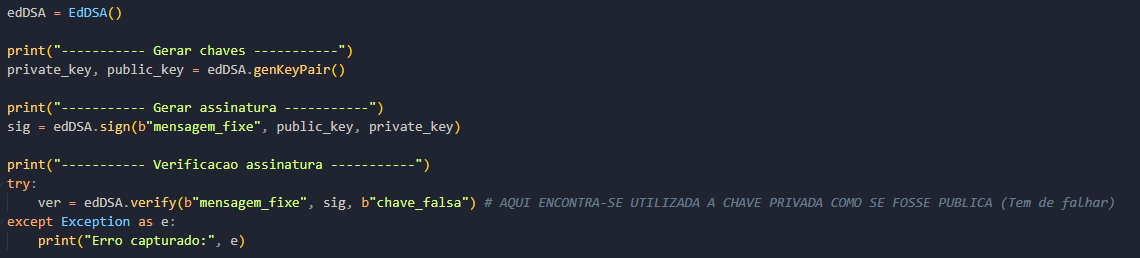

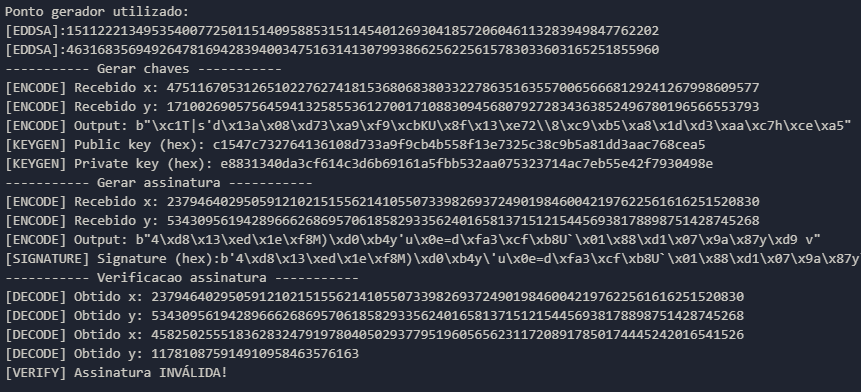

### **Teste de assinatura invalida com um certificado manipulado/diferente**
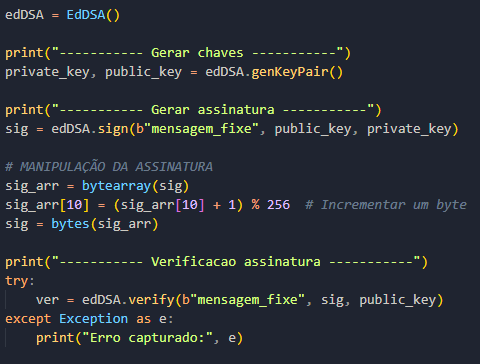

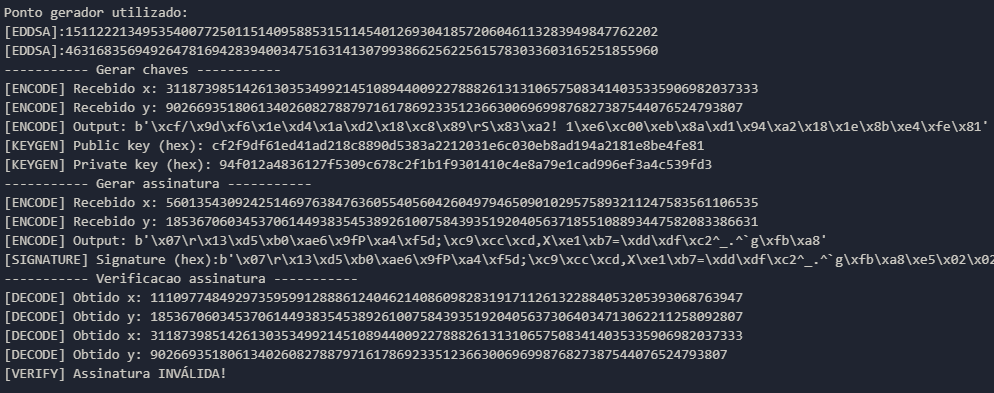

***
# **Referencias:**
[1] NIST, "FIPS 186-5: Digital Signature Standard (DSS)," National Institute of Standards and Technology, Gaithersburg, MD, USA, 2023. [Online]. Disponível em: https://csrc.nist.gov/publications/fips/fips186-5

[2] NIST, "SP 800-186: Recommendations for Discrete Logarithm-Based Cryptography: Elliptic Curve Cryptography," National Institute of Standards and Technology, Gaithersburg, MD, USA, 2010. [Online]. Disponível em: https://csrc.nist.gov/publications/detail/sp/800-186/final

[3] S. Josefsson and I. Liusvaara, "Edwards-Curve Digital Signature Algorithm (EdDSA)", Internet Research Task Force (IRTF), Request for Comments (RFC) 8032, Dec. 2017. [Online]. Disponível em: https://doi.org/10.17487/RFC8032